In [14]:
import pandas as pd
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import bokeh
from bokeh.plotting import figure, show, output_file
import os
import openai
from openai import OpenAI
import backoff
import numpy as np
from sklearn.cluster import KMeans

# Get embedding 

In [2]:
file1 = 'phecode_definitions_with_labels.csv' 
phecode_definitions_df = pd.read_csv(file1)

In [3]:
phecode_definitions_df 

,phecode,phenotype,phecode_exclude_range,sex,rollup,leaf,category_number,category
0,8.00,Intestinal infection,001-009.99,NaN,1,0,1,infectious diseases
1,8.50,Bacterial enteritis,001-009.99,Both,1,0,1,infectious diseases
2,8.51,Intestinal e.coli,001-009.99,Both,1,1,1,infectious diseases
3,8.52,Intestinal infection due to C. difficile,001-009.99,Both,1,1,1,infectious diseases
4,8.60,Viral Enteritis,001-009.99,Both,1,1,1,infectious diseases
...,...,...,...,...,...,...,...,...
1861,994.00,Sepsis and SIRS,994-994.99,NaN,1,0,18,injuries & poisonings
1862,994.10,Systemic inflammatory response syndrome (SIRS),994-994.99,Both,1,1,18,injuries & poisonings
1863,994.20,Sepsis,994-994.99,Both,1,0,18,injuries & poisonings
1864,994.21,Septic shock,994-994.99,Both,1,1,18,injuries & poisonings


In [4]:
file2 = 'Loinc copy.csv'
LOINC_df = pd.read_csv(file2)

/var/folders/pq/qx5x9fj10pj3v7hdcsd6qzz40000gn/T/ipykernel_23189/418038001.py:2: DtypeWarning: Columns (8,15,22,35,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  LOINC_df = pd.read_csv(file2)


In [5]:
combined_LOINC_phecodes_df = pd.merge(phecode_definitions_df, LOINC_df, on='phenotype', how='outer')

In [6]:
openai.api_key = os.environ.get("OPENAI_API_KEY")

In [7]:
import backoff
import requests  # Assuming the client may raise requests exceptions

@backoff.on_exception(backoff.expo, requests.exceptions.RequestException, max_tries=8)
def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    try:
        return openai.embeddings.create(input=[text], model=model).data[0].embedding
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        raise  # Re-raise the exception to trigger backoff

In [8]:
combined_LOINC_phecodes_df['embeddings'] = combined_LOINC_phecodes_df['phenotype'].apply(get_embedding)



In [9]:
# Save the embeddings 

#combined_LOINC_phecodes_df.to_csv('gpt_embedded_combined_LOINC_phecodes_df.csv', index=False)

combined_LOINC_phecodes_df.to_pickle('gpt_embedded_full_LOINC_phecodes_df.pkl')


# Analyze embeddings

In [10]:
file = 'gpt_embedded_full_LOINC_phecodes_df.pkl'
df = pd.read_pickle(file)

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

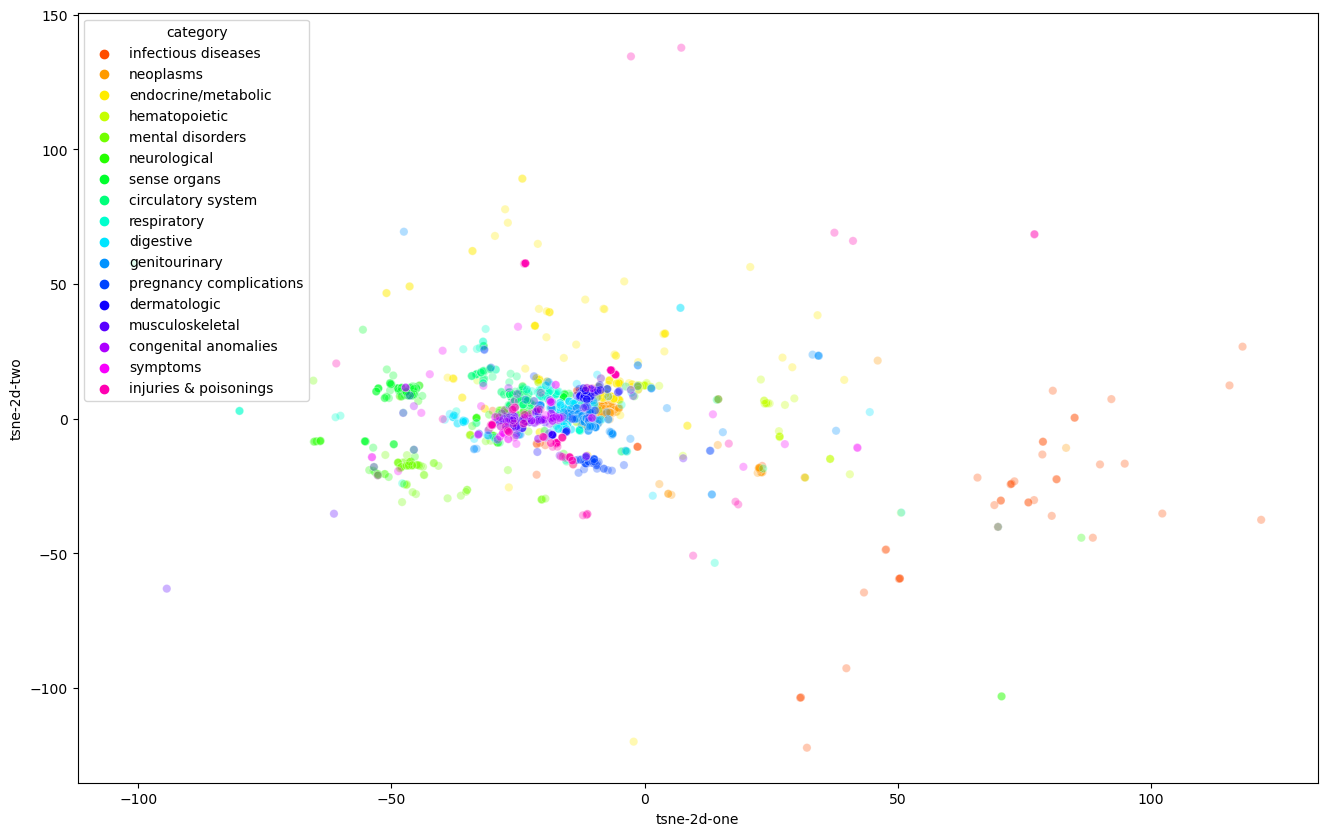

In [11]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataframe
# df = pd.read_csv('your_data.csv')  # Assuming you have your data in a CSV file.

# Extract embeddings into a numpy array
embeddings = np.array(df['embeddings'].tolist())

# Perform BH-tSNE
tsne = TSNE(n_components=2, method='barnes_hut')
tsne_results = tsne.fit_transform(embeddings)

# Create a new dataframe for plotting
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:, 0]
df_tsne['tsne-2d-two'] = tsne_results[:, 1]
df_tsne['category'] = df['category']  # I am assuming you want to color-code by 'category'

# Plot the results
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category",
    palette=sns.color_palette("hsv", len(df_tsne['category'].unique())),
    data=df_tsne,
    legend="full",
    alpha=0.3
)


plt.show()


In [15]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Perform KMeans clustering
matrix = np.vstack(df['embeddings'].values)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['Cluster'] = kmeans.labels_

# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(matrix)

# Map colors to clusters
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Add more colors if you have more clusters
color_map = {i: palette[i] for i in range(n_clusters)}
colors = [color_map[x] for x in df['Cluster']]

# Prepare the data for Bokeh
source = ColumnDataSource(data={
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'phenotype': df['phenotype'],
    'cluster': df['Cluster'],
    'color': colors
})

# Create a figure with a hover tool
p = figure(tools="pan,wheel_zoom,reset,save",
           title="t-SNE visualization of phenotype clusters",
           tooltips="Phenotype: @phenotype")

# Add the points to the plot
p.circle('x', 'y', size=5, color='color', alpha=0.6, source=source)

# Add hover tool
hover = HoverTool()
hover.tooltips = [("Phenotype", "@phenotype"), ("Cluster", "@cluster")]
p.add_tools(hover)

# Before you show the plot, specify the filename for the output.
output_file("LOINC_phecode_tsne_kmeans_visualization_1.html", title="LOINC and Phecodes")

# Show the plot
show(p)

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 104274 samples in 0.073s...
[t-SNE] Computed neighbors for 104274 samples in 139.159s...
[t-SNE] Computed conditional probabilities for sample 1000 / 104274
[t-SNE] Computed conditional probabilities for sample 2000 / 104274
[t-SNE] Computed conditional probabilities for sample 3000 / 104274
[t-SNE] Computed conditional probabilities for sample 4000 / 104274
[t-SNE] Computed conditional probabilities for sample 5000 / 104274
[t-SNE] Computed conditional probabilities for sample 6000 / 104274
[t-SNE] Computed conditional probabilities for sample 7000 / 104274
[t-SNE] Computed conditional probabilities for sample 8000 / 104274
[t-SNE] Computed conditional probabilities for sample 9000 / 104274
[t-SNE] Computed conditional probabilities for sample 10000 / 104274
[t-SNE] Computed conditional probabilities for sample 11000 / 104274
[t-SNE] Computed conditional probabilities for sample 12000 / 104274
[t-SNE] Computed conditional prob

In [16]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np  # Assuming numpy is imported for np.vstack

# Assuming df already includes a 'LOINC' column with LOINC values for each point

# Perform KMeans clustering
matrix = np.vstack(df['embeddings'].values)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['Cluster'] = kmeans.labels_

# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(matrix)

# Map colors to clusters
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Add more colors if you have more clusters
color_map = {i: palette[i] for i in range(n_clusters)}
colors = [color_map[x] for x in df['Cluster']]

# Prepare the data for Bokeh
source = ColumnDataSource(data={
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'phenotype': df['phenotype'],
    'cluster': df['Cluster'],
    'LOINC': df['LOINC'],  # Assuming 'LOINC' is the column name
    'color': colors
})

# Create a figure with a hover tool
p = figure(tools="pan,wheel_zoom,reset,save",
           title="t-SNE visualization of phenotype clusters",
           tooltips=[("Phenotype", "@phenotype"), ("Cluster", "@cluster")])

# Add the points to the plot
p.circle('x', 'y', size=5, color='color', alpha=0.6, source=source)

# Add hover tool with LOINC values
hover = HoverTool()
hover.tooltips = [("Phenotype", "@phenotype"), ("Cluster", "@cluster"), ("LOINC", "@LOINC")]
p.add_tools(hover)

# Before you show the plot, specify the filename for the output.
output_file("LOINC_phecode_tsne_kmeans_visualization_2.html", title="LOINC and Phecodes")


# Show the plot
show(p)


/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 104274 samples in 0.067s...
[t-SNE] Computed neighbors for 104274 samples in 135.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 104274
[t-SNE] Computed conditional probabilities for sample 2000 / 104274
[t-SNE] Computed conditional probabilities for sample 3000 / 104274
[t-SNE] Computed conditional probabilities for sample 4000 / 104274
[t-SNE] Computed conditional probabilities for sample 5000 / 104274
[t-SNE] Computed conditional probabilities for sample 6000 / 104274
[t-SNE] Computed conditional probabilities for sample 7000 / 104274
[t-SNE] Computed conditional probabilities for sample 8000 / 104274
[t-SNE] Computed conditional probabilities for sample 9000 / 104274
[t-SNE] Computed conditional probabilities for sample 10000 / 104274
[t-SNE] Computed conditional probabilities for sample 11000 / 104274
[t-SNE] Computed conditional probabilities for sample 12000 / 104274
[t-SNE] Computed conditional prob

KeyError: 'LOINC'

In [ ]:
import pandas as pd

# Load 'MCL LOINC Values' DataFrame (adjust the file path as necessary)
mcl_loinc_values = pd.read_csv('MCL LOINC Values.csv', header=1) 




In [ ]:
mcl_loinc_values

In [ ]:


# Create a dictionary from the 'MCL LOINC Values' DataFrame
loinc_dict = pd.Series(mcl_loinc_values['Test Order Name'].values, index=mcl_loinc_values['Order LOINC Code']).to_dict()

# Map 'LOINC' values in 'df' to 'Test Order Name' using the created dictionary
# NaN values in 'LOINC' will remain NaN in the new column if there's no matching key in the dictionary
df['Test Order Name'] = df['LOINC'].map(loinc_dict)



In [ ]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np  # Assuming numpy is imported for np.vstack

# Assuming df already includes a 'LOINC' column with LOINC values for each point

# Perform KMeans clustering
matrix = np.vstack(df['embeddings'].values)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['Cluster'] = kmeans.labels_

# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(matrix)

# Map colors to clusters
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Add more colors if you have more clusters
color_map = {i: palette[i] for i in range(n_clusters)}
colors = [color_map[x] for x in df['Cluster']]



In [ ]:
from bokeh.models import HoverTool, LabelSet, ColumnDataSource, CustomJS, TapTool
from bokeh.plotting import figure, show
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np

# ... your existing code for KMeans clustering and t-SNE ...

# Prepare the data for Bokeh, ensuring test_order_name is a string, replacing NaN with empty strings
source = ColumnDataSource(data={
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'phenotype': df['phenotype'],
    'cluster': df['Cluster'],
    'LOINC': df['LOINC'],
    'test_order_name': df['Test Order Name'].fillna(''),  # Replace NaN with empty string
    'color': colors
})

# Create a figure with hover tool enabled
p = figure(tools="pan,wheel_zoom,reset,save,tap",
           title="t-SNE visualization of phenotype clusters")

# Add the points to the plot
p.circle('x', 'y', size=5, color='color', alpha=0.6, source=source)

# Define hover tool for all points
hover = HoverTool(tooltips=[("Phenotype", "@phenotype"),
                            ("Test Order Name", "@test_order_name")])
p.add_tools(hover)

# Add labels for points with non-empty test order names
labels = LabelSet(x='x', y='y', text='test_order_name', level='glyph',
                  x_offset=5, y_offset=5, source=source, text_font_size="5pt",
                  text_color='black')
p.add_layout(labels)

# Before you show the plot, specify the filename for the output.
output_file("LOINC_phecode_tsne_kmeans_visualization_3.html", title="LOINC and Phecodes")

# Show the plot
show(p)


In [47]:
# save the plot

from bokeh.plotting import output_file, save

# Set up your plot as before

# Specify the output file name
output_file("Phecode_LOINC_TSNE_visualization.html")

save(p)

'/Users/ellenbowen/Desktop/Michigan/Siwo_lab/Phecode_LOINC_TSNE_visualization.html'

# Color-coding LOINC values

In [13]:
import numpy as np
import pandas as pd  # Assuming pandas is used for DataFrame operations
from bokeh.models import HoverTool, LabelSet, ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.transform import linear_cmap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import colorsys

# Assuming df is your DataFrame and tsne_results are already computed

def generate_colors(N):
    HSV_tuples = [(x * 1.0 / N, 0.5, 0.5) for x in range(N)]
    hex_colors = []
    for hsv in HSV_tuples:
        rgb = colorsys.hsv_to_rgb(*hsv)
        hex_colors.append('#' + ''.join(f"{int(c*255):02x}" for c in rgb))
    return hex_colors

# Generate a unique color for each LOINC code
unique_loinc_codes = df['LOINC'].unique()
colors = generate_colors(len(unique_loinc_codes))

# Map each LOINC code to a color
loinc_color_map = {loinc: colors[i] for i, loinc in enumerate(unique_loinc_codes)}
df['color'] = df['LOINC'].map(loinc_color_map)

# Continue with your existing setup
source = ColumnDataSource(data={
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'phenotype': df['phenotype'],
    'cluster': df['Cluster'],
    'LOINC': df['LOINC'],
    'test_order_name': df['Test Order Name'].fillna(''),  # Replace NaN with empty string
    'color': df['color']
})

# Create a figure with hover tool enabled
p = figure(tools="pan,wheel_zoom,reset,save,tap",
           title="t-SNE visualization of phenotype clusters")

# Add the points to the plot
p.circle('x', 'y', size=5, color='color', alpha=0.6, source=source)

# Define hover tool for all points
hover = HoverTool(tooltips=[("Phenotype", "@phenotype"),
                            ("Test Order Name", "@test_order_name"),
                            ("LOINC", "@LOINC")])  # Add LOINC to hover tool
p.add_tools(hover)

# Add labels for points with non-empty test order names
labels = LabelSet(x='x', y='y', text='test_order_name', level='glyph',
                  x_offset=5, y_offset=5, source=source, text_font_size="5pt",
                  text_color='black')
p.add_layout(labels)

# Show the plot
show(p)
